In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from scipy.optimize import curve_fit

sns.set(style="whitegrid")

csv_path = "wandb_data/4 dyn200 results/"

In [3]:
# [aeal3bid](https://wandb.ai/s-ruff-tu-delft/NoisyNeuralNet-v7/sweeps/aeal3bid)
df_con_noisy_reward   = pd.read_csv(csv_path + "Con NoisyNet 0 9 reward.csv")
df_con_noisy_regret   = pd.read_csv(csv_path + "Con NoisyNet 0 9 regret.csv")
df_con_noisy_expl     = pd.read_csv(csv_path + "Con NoisyNet 0 9 exploration_rate.csv")
df_nn_noisy_reward    = pd.read_csv(csv_path +  "NN NoisyNet 0 9 reward.csv")
df_nn_noisy_regret    = pd.read_csv(csv_path +  "NN NoisyNet 0 9 regret.csv")
df_nn_noisy_expl      = pd.read_csv(csv_path +  "NN NoisyNet 0 9 exploration_rate.csv")
df_con_regular_reward = pd.read_csv(csv_path + "Con regular 0 9 reward.csv")
df_con_regular_regret = pd.read_csv(csv_path + "Con regular 0 9 regret.csv")
df_con_regular_expl   = pd.read_csv(csv_path + "Con regular 0 9 exploration_rate.csv")
df_nn_regular_reward  = pd.read_csv(csv_path +  "NN regular 0 9 reward.csv")
df_nn_regular_regret  = pd.read_csv(csv_path +  "NN regular 0 9 regret.csv")
df_nn_regular_expl    = pd.read_csv(csv_path +  "NN regular 0 9 exploration_rate.csv")

def drop_min_max_columns(df):
    return df[[col for col in df.columns if not (col.endswith('__MIN') or col.endswith('__MAX'))]]

df_con_noisy_reward   = drop_min_max_columns(df_con_noisy_reward)
df_con_noisy_regret   = drop_min_max_columns(df_con_noisy_regret)
df_con_noisy_expl     = drop_min_max_columns(df_con_noisy_expl)
df_nn_noisy_reward    = drop_min_max_columns(df_nn_noisy_reward)
df_nn_noisy_regret    = drop_min_max_columns(df_nn_noisy_regret)
df_nn_noisy_expl      = drop_min_max_columns(df_nn_noisy_expl)
df_con_regular_reward = drop_min_max_columns(df_con_regular_reward)
df_con_regular_regret = drop_min_max_columns(df_con_regular_regret)
df_con_regular_expl   = drop_min_max_columns(df_con_regular_expl)
df_nn_regular_reward  = drop_min_max_columns(df_nn_regular_reward)
df_nn_regular_regret  = drop_min_max_columns(df_nn_regular_regret)
df_nn_regular_expl    = drop_min_max_columns(df_nn_regular_expl)

In [4]:
# df_nn_noisy_stat_expl.info()

In [5]:
# df = df_nn_noisy_stat_expl

# exploration_cols = df.columns.drop('Step')

# plt.figure(figsize=(12, 3 * len(exploration_cols)))

# for i, col in enumerate(exploration_cols, 1):
#     plt.subplot(len(exploration_cols), 1, i)
#     sns.lineplot(data=df, x='Step', y=col)
#     plt.title(col)
#     plt.xlabel('Step')
#     plt.ylabel('Exploration Rate')

# plt.tight_layout()
# plt.show()

In [6]:
def plot_with_sem(df):
    data = df.drop(columns='Step')
    
    mean_vals = data.mean(axis=1)
    sem_vals = data.sem(axis=1)
    
    steps = df['Step']
    
    window = 50
    mean_vals_smooth = mean_vals.rolling(window, center=True, min_periods=1).mean()
    sem_vals_smooth = sem_vals.rolling(window, center=True, min_periods=1).mean()
    
    plt.figure(figsize=(12,6))
    plt.plot(steps, mean_vals_smooth, label='Smoothed Mean Exploration Rate')
    plt.fill_between(
        steps, 
        mean_vals_smooth - sem_vals_smooth,
        mean_vals_smooth + sem_vals_smooth,
        alpha=0.3,
        label='Smoothed SEM',
        color='orange'
    )
    plt.xlabel('Step')
    plt.ylabel('Exploration Rate')
    plt.title('Smoothed Mean Exploration Rate with SEM')
    plt.legend()
    plt.show()

In [7]:
# plot_with_sem(df_con_noisy_stat_reward)

In [8]:
def plot_metric_grid(dataset1, dataset2, suptitle=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    window = 50
    
    for ax, metric_name in zip(axes, ['reward', 'regret', 'exploration_rate']):
        df1 = dataset1.get(metric_name)
        df2 = dataset2.get(metric_name)
        
        data1 = df1.drop(columns='Step')
        mean_vals1 = data1.mean(axis=1)
        sem_vals1 = data1.sem(axis=1)
        data2 = df2.drop(columns='Step')
        mean_vals2 = data2.mean(axis=1)
        sem_vals2 = data2.sem(axis=1)
        steps = df1['Step']
        
        mean_smooth1 = mean_vals1.rolling(window, center=True, min_periods=1).mean()
        sem_smooth1 = sem_vals1.rolling(window, center=True, min_periods=1).mean()
        mean_smooth2 = mean_vals2.rolling(window, center=True, min_periods=1).mean()
        sem_smooth2 = sem_vals2.rolling(window, center=True, min_periods=1).mean()
        
        ax.plot(steps, mean_smooth1, label='NoisyNet-DQN')
        ax.plot(steps, mean_smooth2, label='Regular DQN')
        ax.fill_between(
            steps,
            mean_smooth1 - sem_smooth1,
            mean_smooth1 + sem_smooth1,
            alpha=0.2,
            color='blue',
            label='NoisyNet-DQN SEM'
        )
        ax.fill_between(
            steps,
            mean_smooth2 - sem_smooth2,
            mean_smooth2 + sem_smooth2,
            alpha=0.3,
            color='orange',
            label='regular DQN SEM'
        )
        ax.set_title(metric_name.capitalize())
        ax.set_xlabel('Step')
        ax.set_ylabel(metric_name.capitalize())
        ax.legend()
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"results/{suptitle} results.png", dpi=300, bbox_inches='tight')
    plt.show()

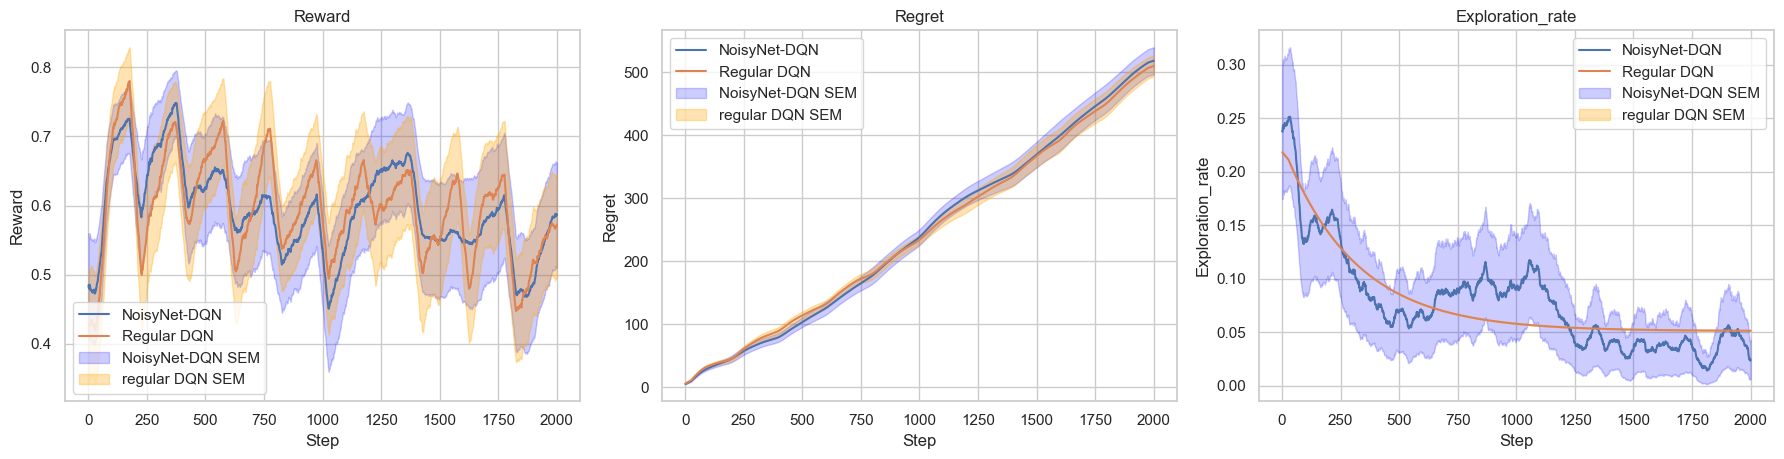

In [9]:
dataset1 = {
    'reward': df_con_noisy_reward,
    'regret': df_con_noisy_regret,
    'exploration_rate': df_con_noisy_expl
}
dataset2 = {
    'reward': df_con_regular_reward,
    'regret': df_con_regular_regret,
    'exploration_rate': df_con_regular_expl
}

plot_metric_grid(dataset1, dataset2, suptitle="ContextualBandit dyn200")

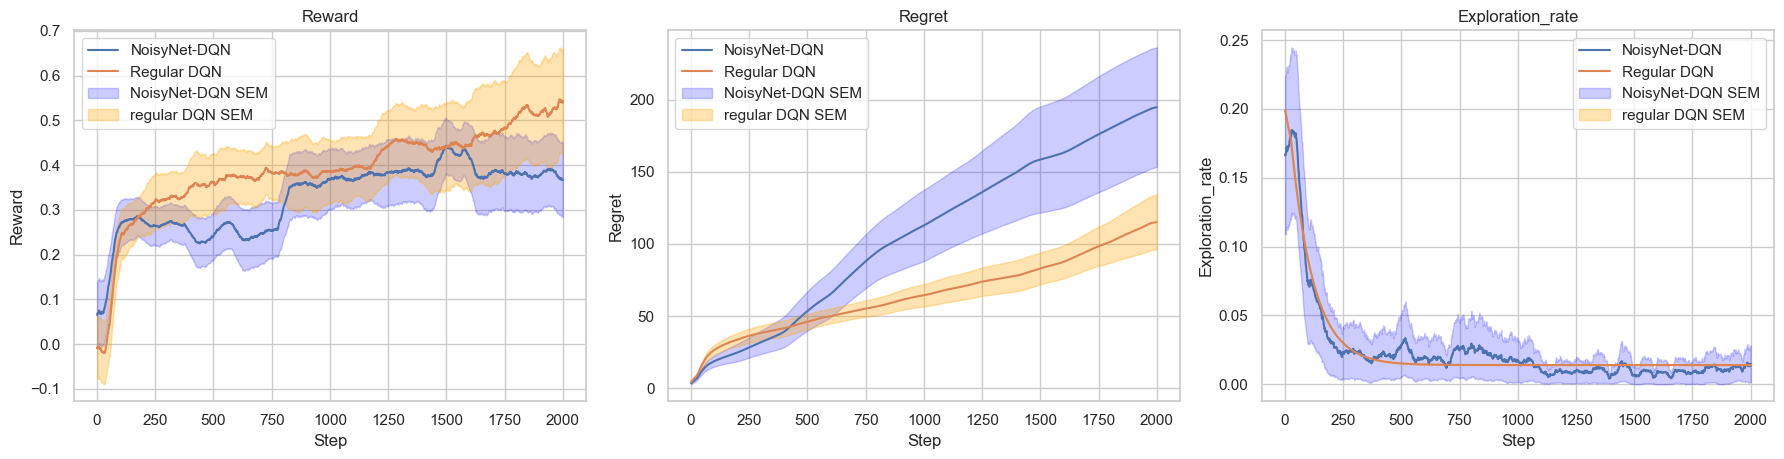

In [10]:
dataset1 = {
    'reward': df_nn_noisy_reward,
    'regret': df_nn_noisy_regret,
    'exploration_rate': df_nn_noisy_expl
}
dataset2 = {
    'reward': df_nn_regular_reward,
    'regret': df_nn_regular_regret,
    'exploration_rate': df_nn_regular_expl
}

plot_metric_grid(dataset1, dataset2, suptitle="NNBandit dyn200")

In [10]:
def epsilon_decay(t, a, b, c):
    return a * np.exp(-b * t) + c

def fit_epsilon_decay(steps, mean_exploration_rate):
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
    popt, pcov = curve_fit(epsilon_decay, steps, mean_exploration_rate, bounds=([0,0,0],[1,1,1]))
    
    fitted_vals = epsilon_decay(steps, *popt)
    
    plt.figure(figsize=(12, 6))
    plt.plot(steps, mean_exploration_rate)
    plt.plot(steps, fitted_vals)
    print(f'a={popt[0]:.3f}, b={popt[1]:.5f}, c={popt[2]:.3f}')
    plt.show()

a=0.174, b=0.00325, c=0.051


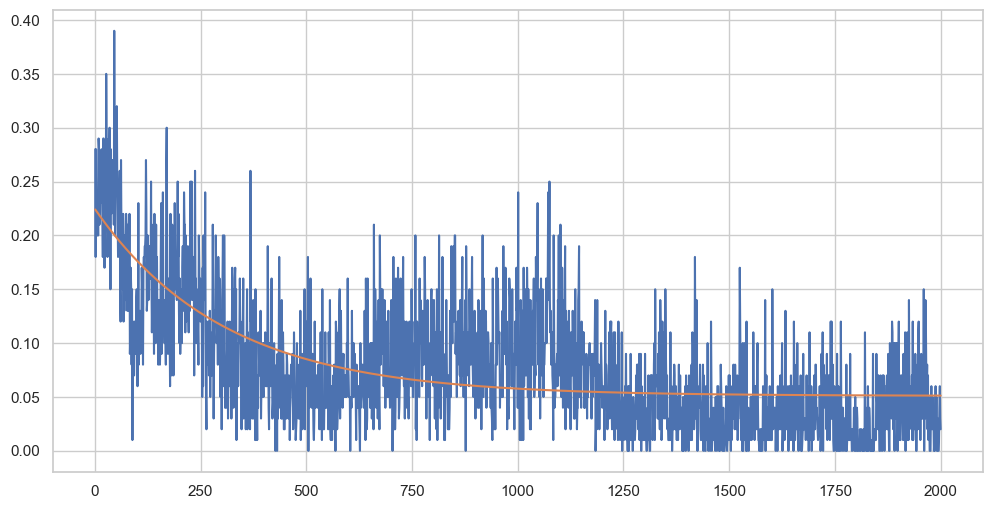

In [11]:
steps = df_con_noisy_expl['Step']
mean_exploration_rate = df_con_noisy_expl.drop(columns='Step').mean(axis=1)
fit_epsilon_decay(steps, mean_exploration_rate)

a=0.209, b=0.01039, c=0.014


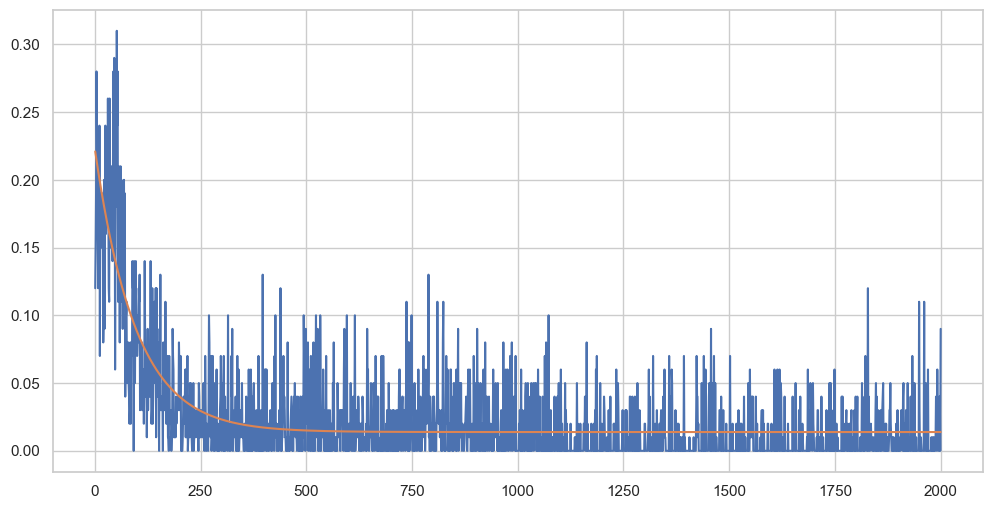

In [12]:
steps = df_nn_noisy_expl['Step']
mean_exploration_rate = df_nn_noisy_expl.drop(columns='Step').mean(axis=1)
fit_epsilon_decay(steps, mean_exploration_rate)